In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib 
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


For estimating the probabilities $\vec p$ given the observed counts $\vec c$, we use the conjugacy between the Dirichlet and Multinomial distributions

$$\vec p \sim \mathcal{Dir}(\vec \alpha)$$
$$\vec c | \vec p \sim \mathcal{MN}(\vec p | \vec c)$$

where $\vec \alpha$ controls the prior expectation about the probabilities of each response. There are typically two non-informative choices we can make, specifically, $\vec \alpha = \vec 1$ and $\vec \alpha = \vec{0.5}$. In both cases, the prior expected probability is equal for each response (i.e. no preference for any response). For the $\vec \alpha = \vec 1$ case, all probabilities are equally likely, while the  $\vec \alpha = \vec{0.5}$ case is the Jeffrey's prior, which has a slight preference to find a high probability in one entry and low probabilities in the other entries. For this work, we use the $\vec \alpha = \vec 1$ condition. 

We find that the posterior $\vec p$ is given by: 

$$\vec p | \vec c \sim \mathcal{Dir}(\vec\alpha + \vec c)$$

where the expectation and variance of $p_i$ is given by:
$$\alpha_0 = \sum_i (\alpha_i+c_i)$$
$$E(p_i) = \frac{\alpha_i+c_i}{\alpha_0}$$
$$V(p_i) = \frac{(\alpha_i+c_i)(\alpha_0-\alpha_i-c_i)}{\alpha_0^2(\alpha_0+1)}$$


In [23]:
fname = 'Community_and_Culture_Committee_survey_2025 (Responses) - Sheet1.csv'

with open(fname) as f:    
    lines = f.readlines()

In [24]:
question_count = 0
question_dict = {}

in_question = False
for line in lines:
    if line.startswith('Question'):
        in_question = True
        question_dict[question_count] = [line]
        continue
    elif line.startswith(',,'):
        if in_question:
            question_count += 1
        in_question = False
        
    if in_question:
        question_dict[question_count].append(line)




In [25]:
question_dict[list(question_dict.keys())[0]]

['Question,"I have been offered X amount of training in equity diversity and inclusion (EDI) issues from the department. [1 = too little; 3 = a perfect; 5 = too much.]",,,,,\n',
 ',too little,,,,too much,total\n',
 'Response,1,2,3,4,5,\n',
 '2025,6,22,31,6,3,68\n',
 '2024,11,35,34,2,3,85\n',
 '2023,4,10,8,7,1,30\n']

In [71]:
n_sample = 1000 #for creating CI
ci_range = 16,84 #68% CI
samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)

np.percentile(samples,ci_range,axis=0)-np.nanmedian(samples,axis=0)


array([[-0.07491082, -0.07588676, -0.04523152, -0.02628071, -0.02498005],
       [ 0.07340583,  0.07853663,  0.06304254,  0.04364138,  0.04095585]])

In [66]:
data[year]['probs']

array([0.36842105, 0.39473684, 0.13157895, 0.05263158, 0.05263158])

In [90]:
color_hex = [
    '#4483F3',
    '#EA4336',
    '#FBBD05',    
]

0 "I have been offered X amount of training in equity diversity and inclusion (EDI) issues from the department. [1 = too little; 3 = a perfect; 5 = too much.]"


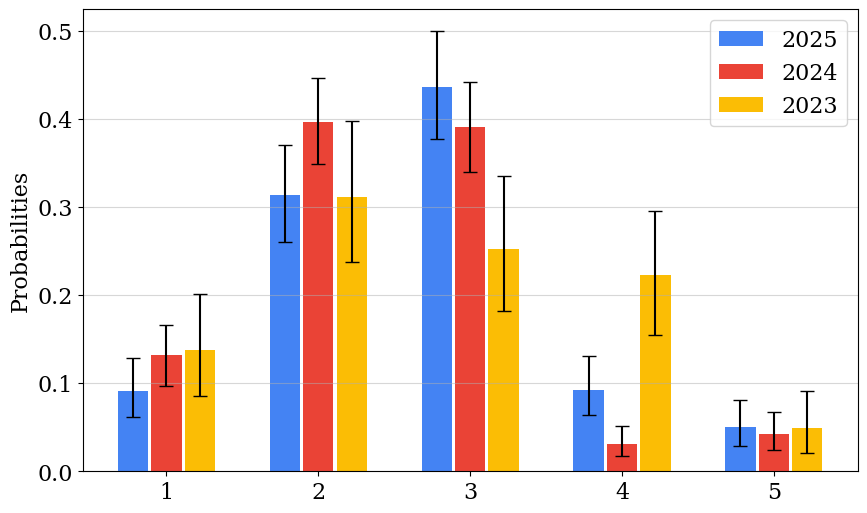

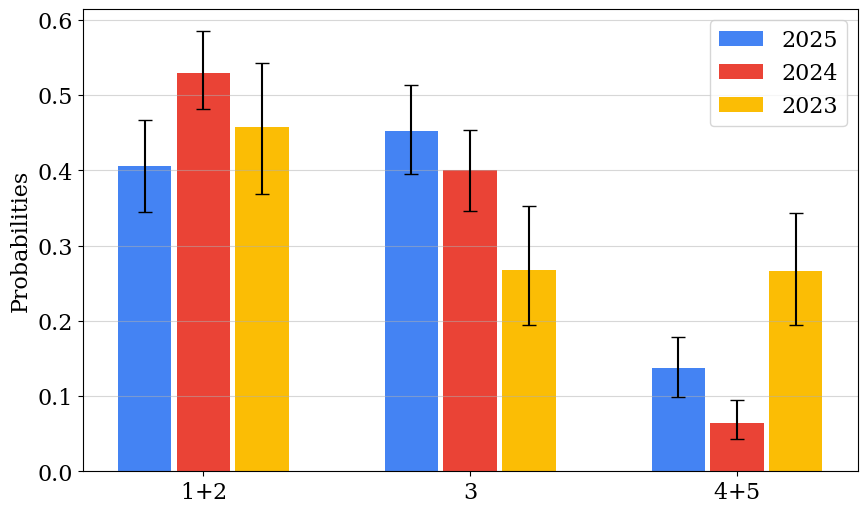

1 My mental health is in a healthy state.


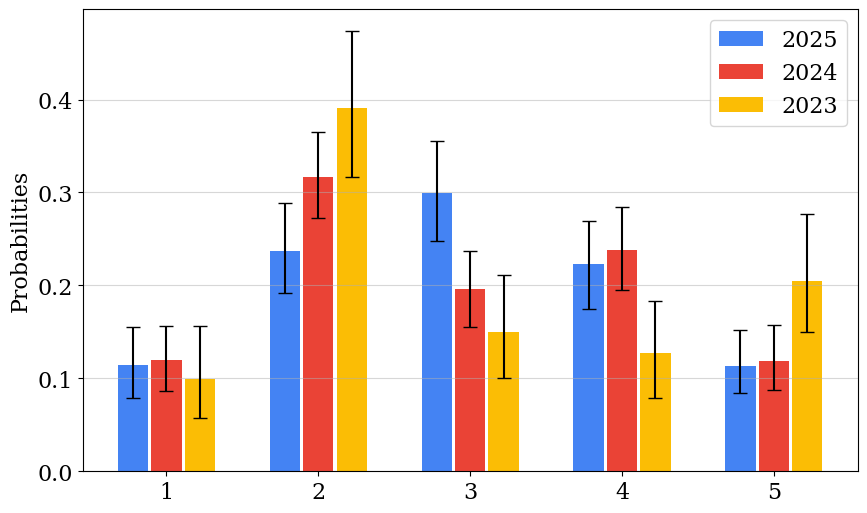

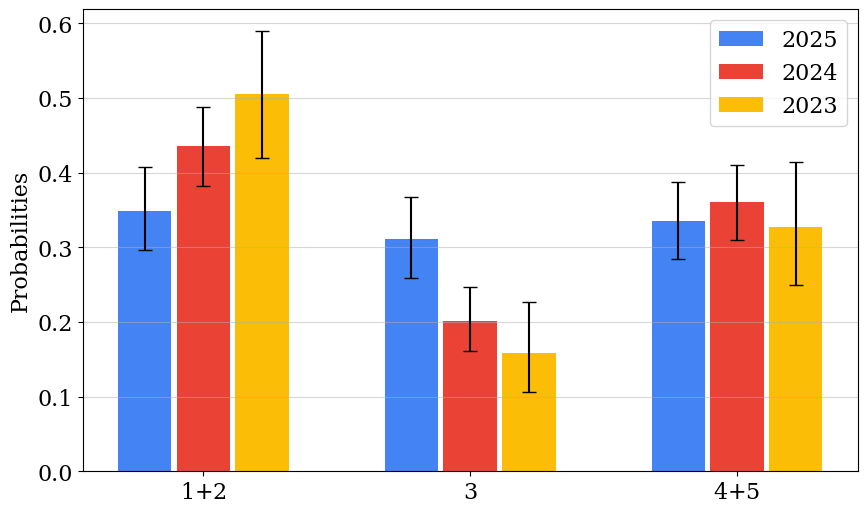

2 I have been offered X amount of mental health support from the department. [1 = too little; 3 = a perfect; 5 = too much.]


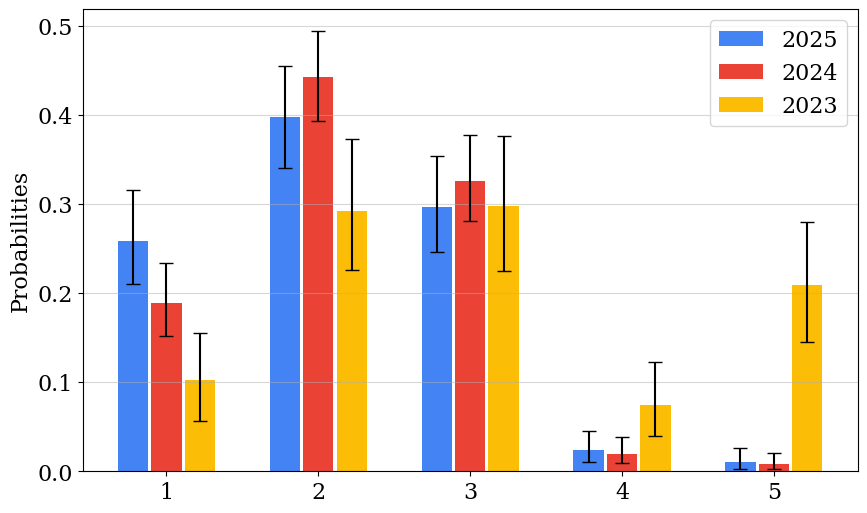

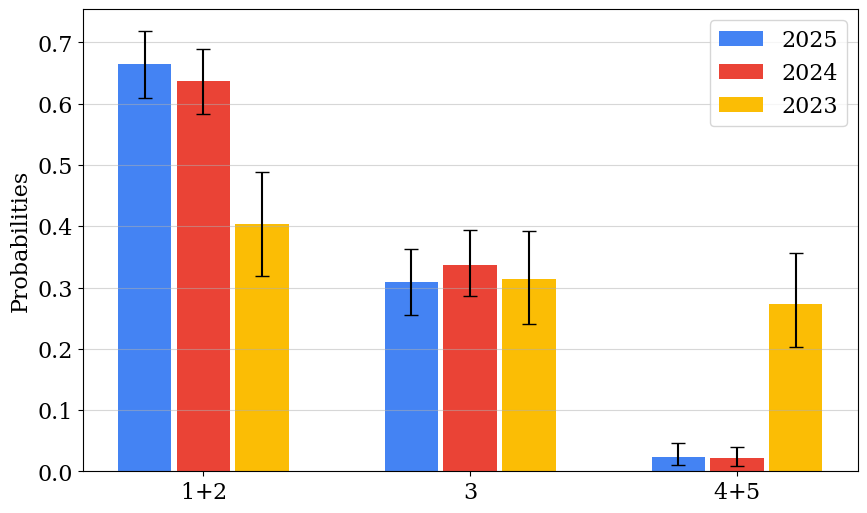

3 I know where to find resources or who to contact in case of mental health problems


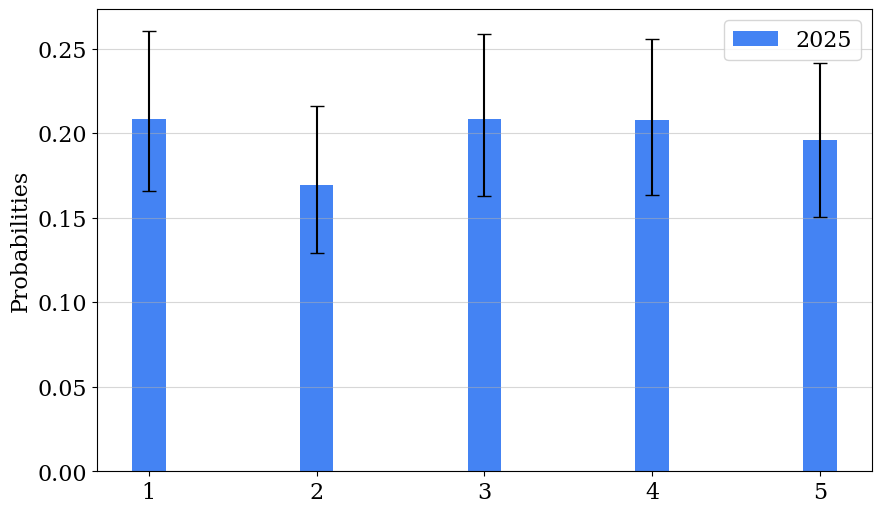

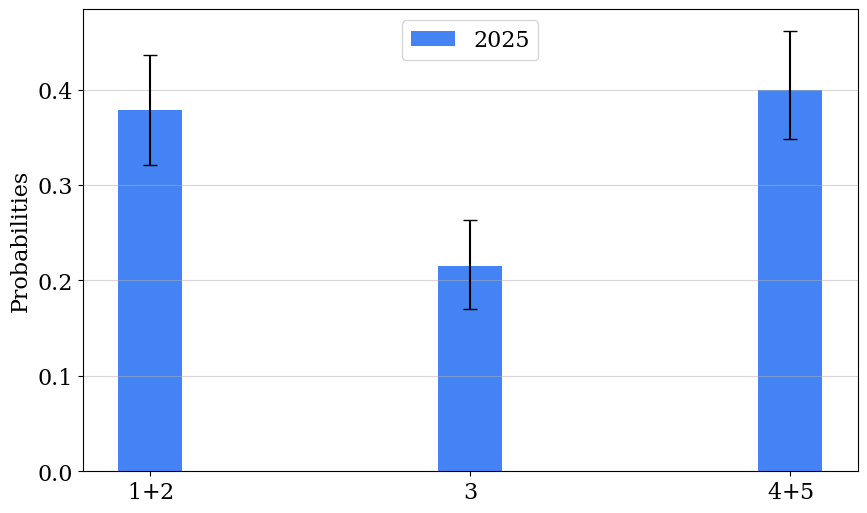

4 I can approach (other) faculty members for questions or discussions when I need.


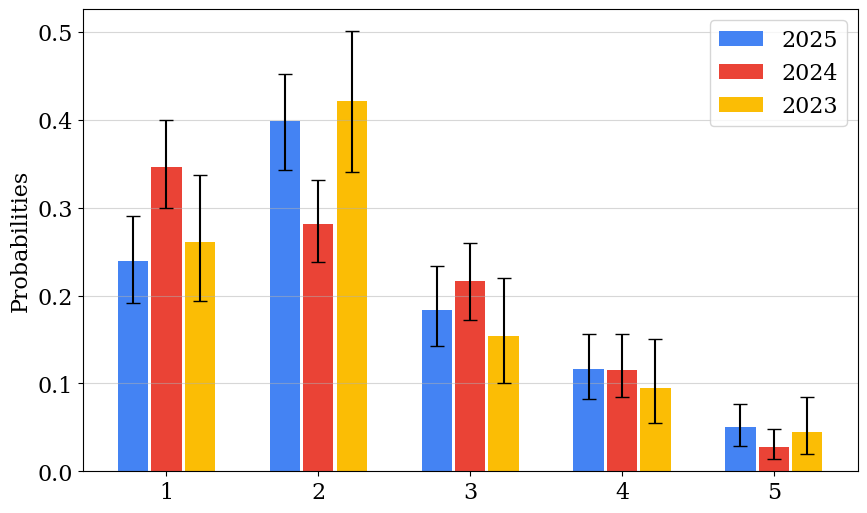

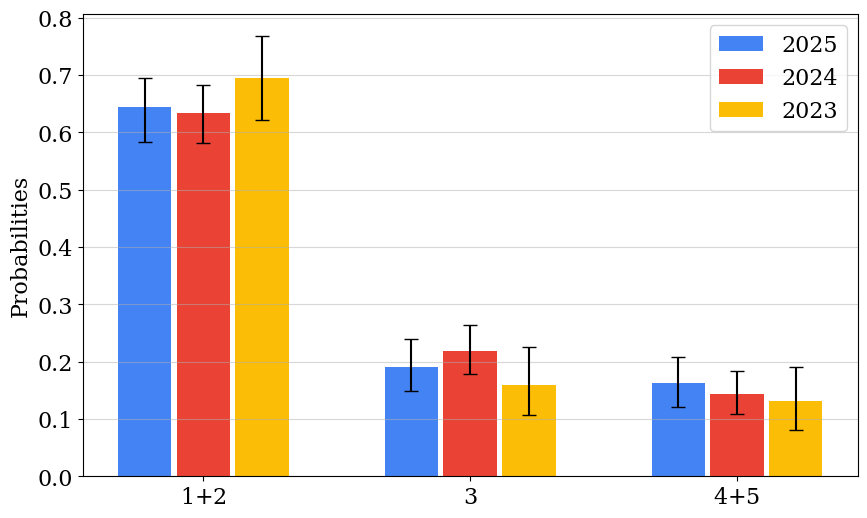

5 I am aware of the events that are happening in the department and I know where to find information about them.


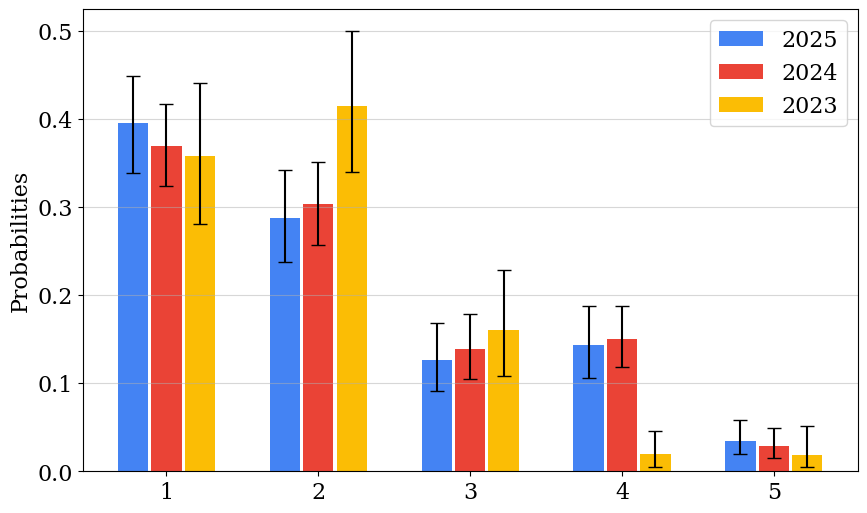

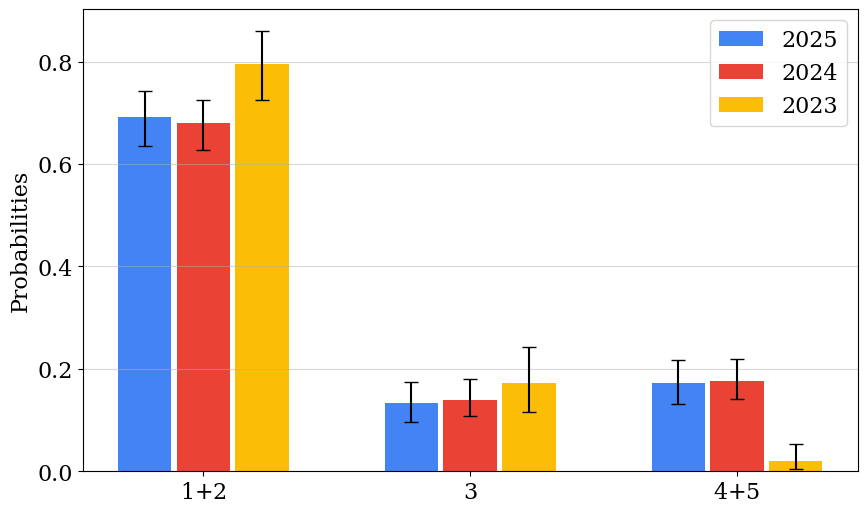

6 My class/teaching/research schedule allows me to attend the weekly TASTY talks and colloquia.


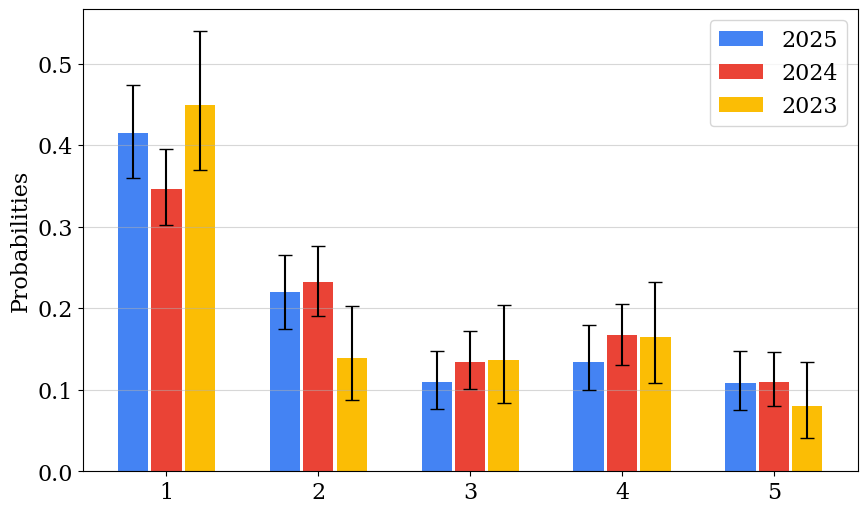

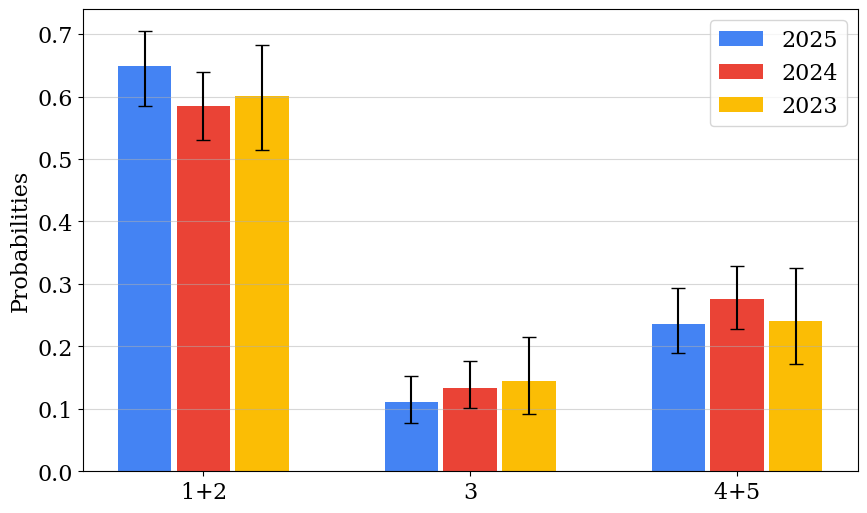

7 "The balance between in-person and virtual interaction (e.g. talks; one-on-one meetings; classes) in the department post-COVID is good."


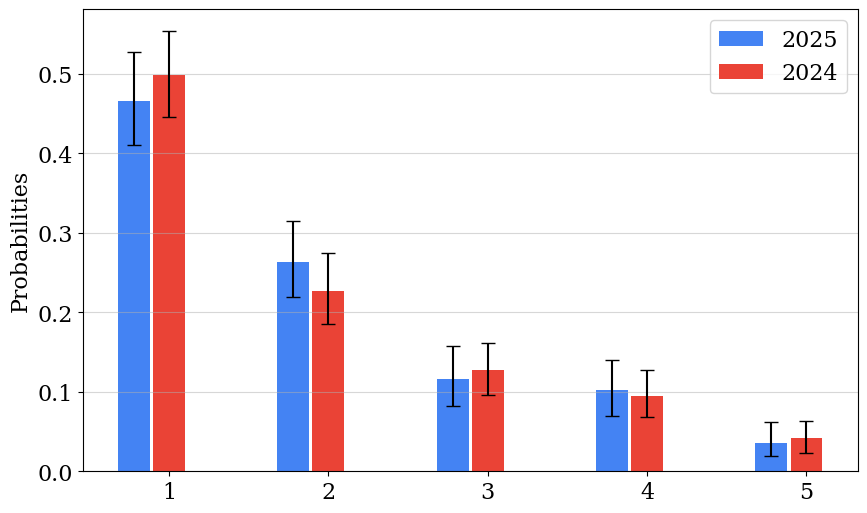

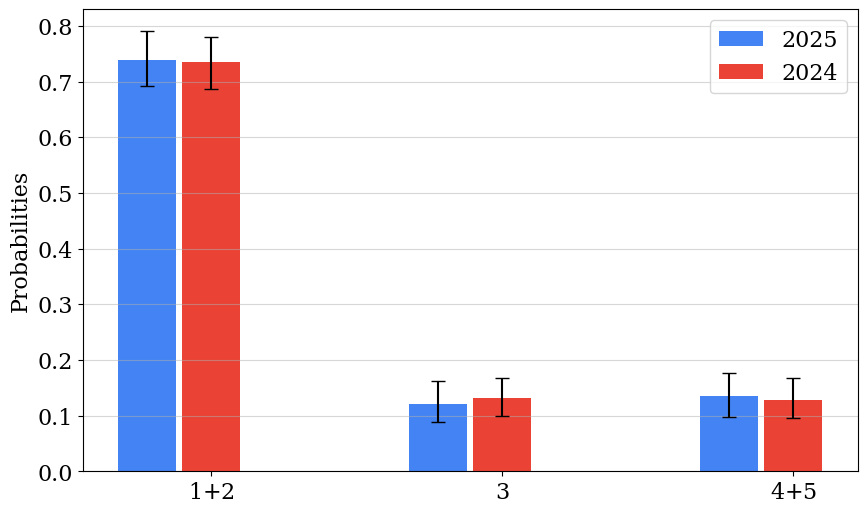

8 I have access to all the academic resources that I need.


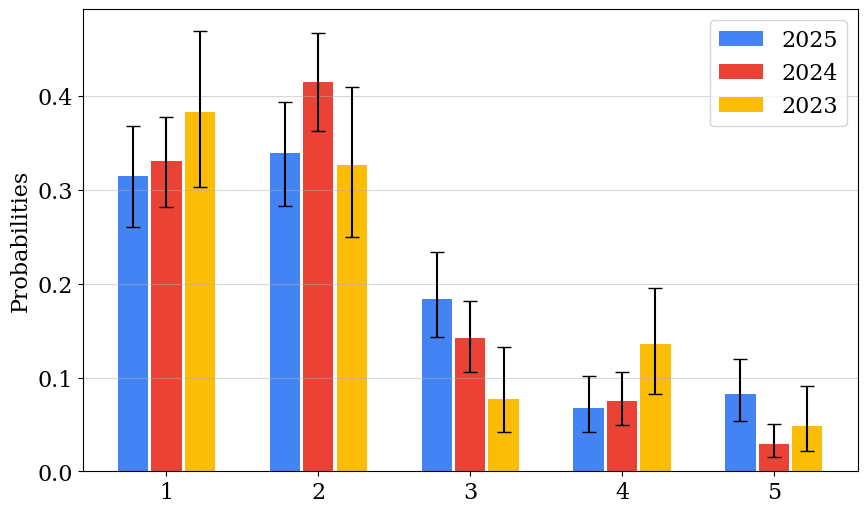

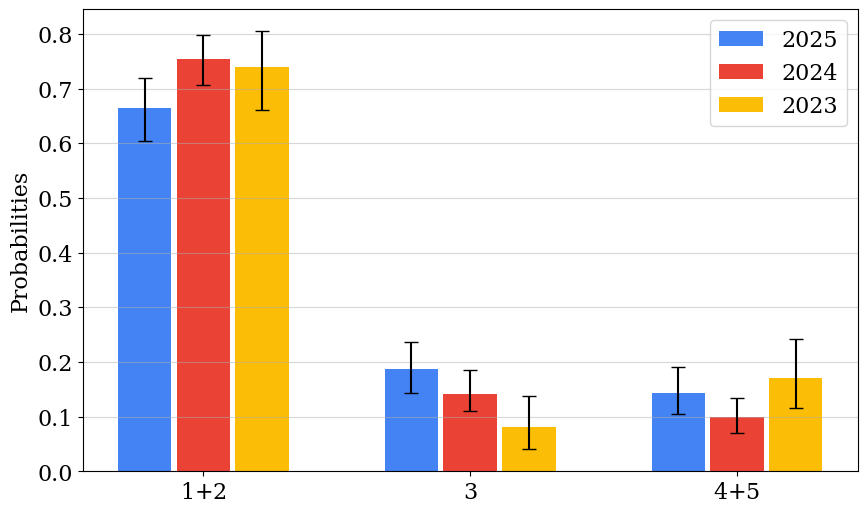

9 I have access to all the academic mentorship that I need.


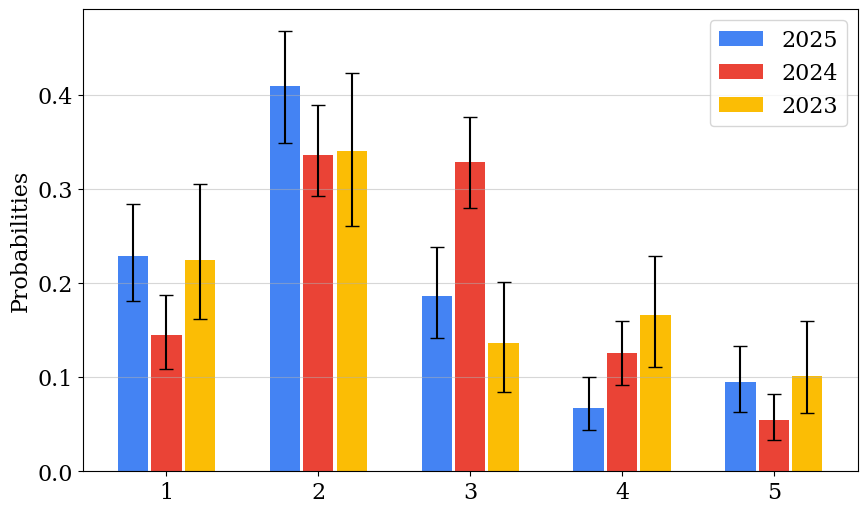

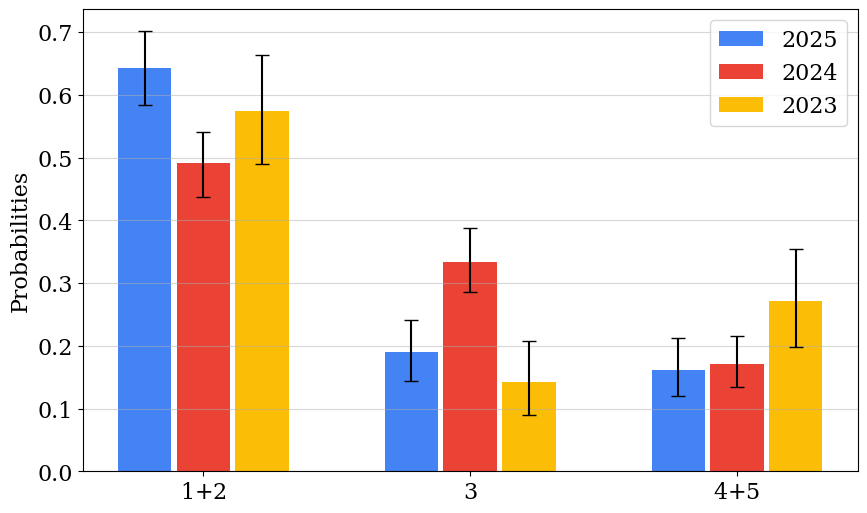

10 The physical condition of the AB building allows me to work comfortably in person.


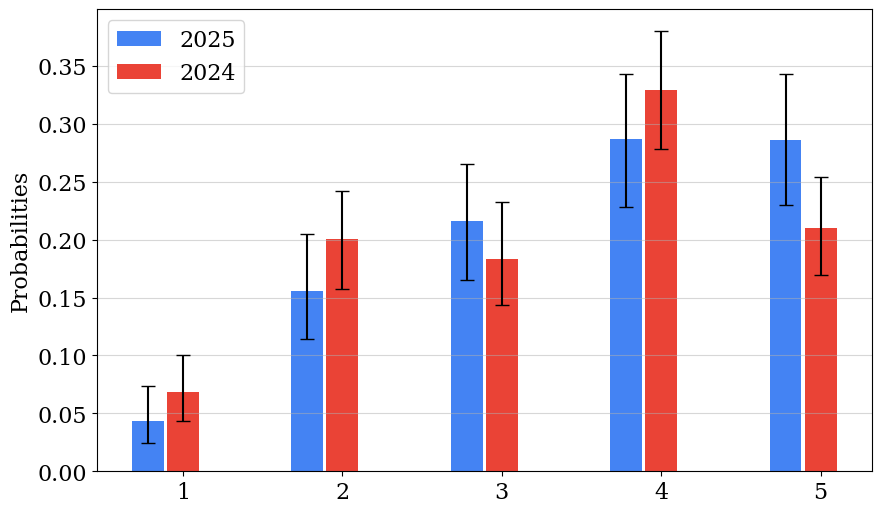

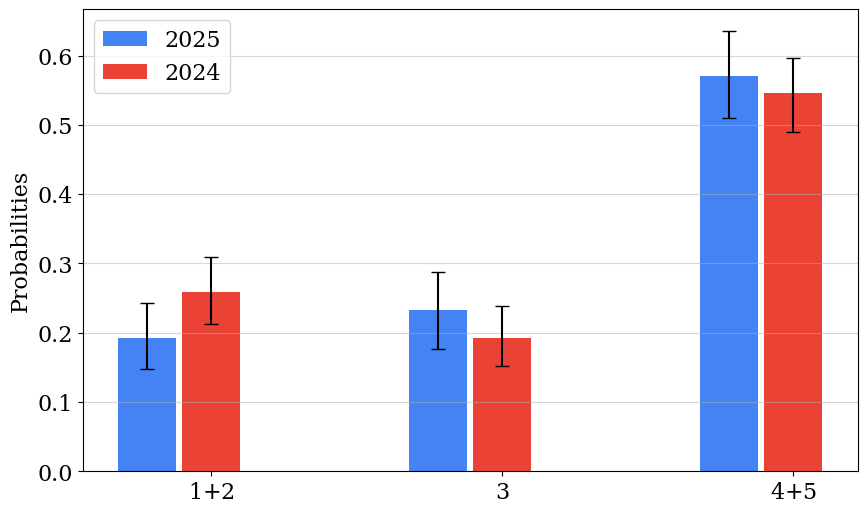

11 The physical condition of the MP building allows me to work comfortably in person.


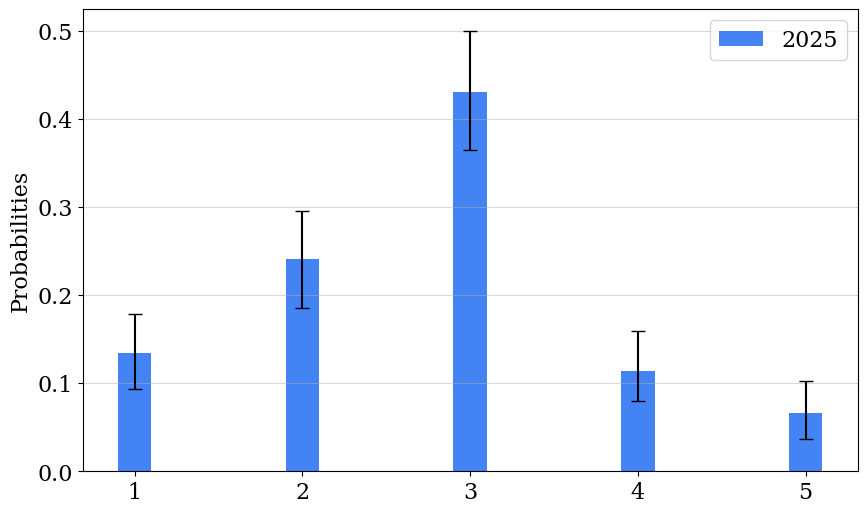

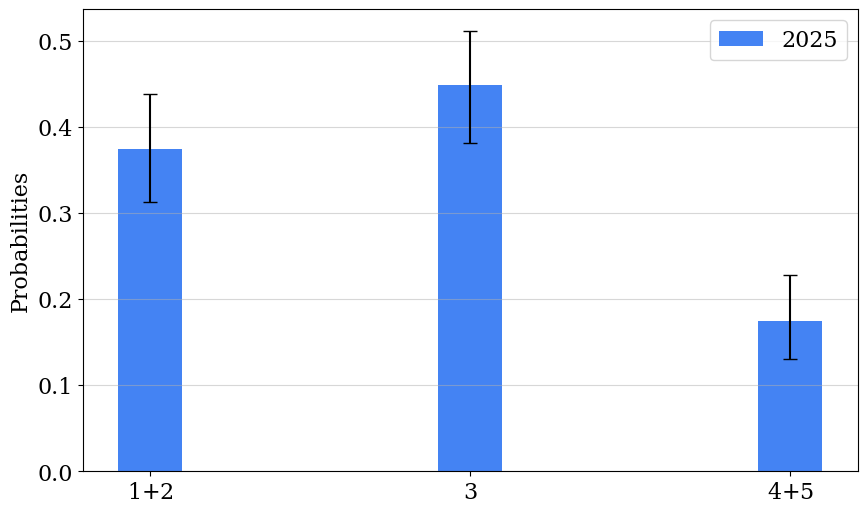

12 The Community and Culture Committee (CCC) is making X impact on the departmental atmosphere. [1 = too little; 3 = a perfect; 5 = too much.]


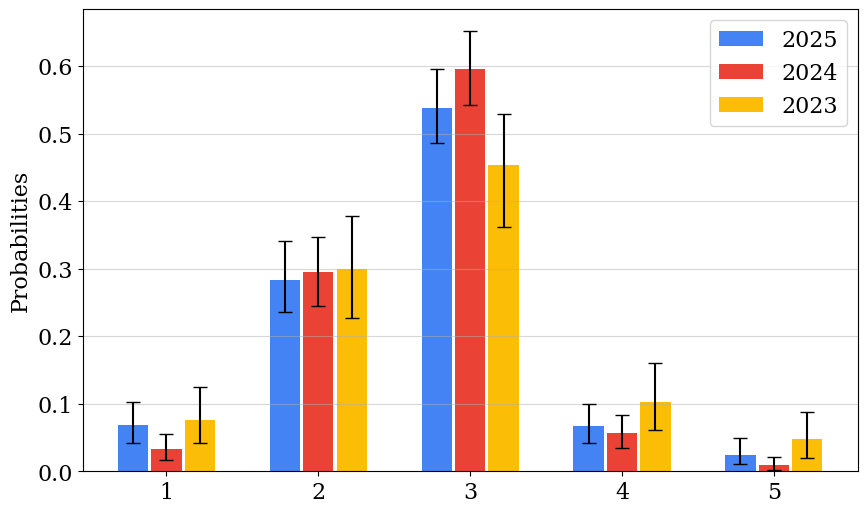

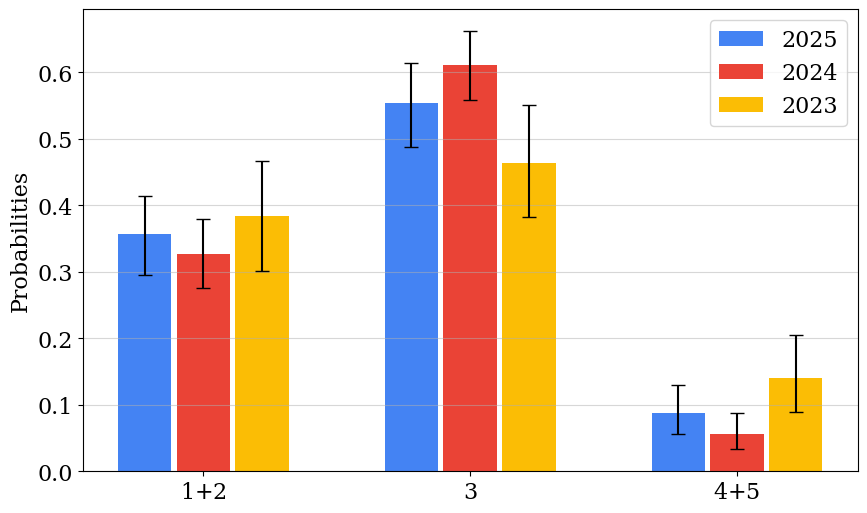

13 "Previously: ""The department is welcoming for all its members."" Now: ""I feel welcome in my home department"""


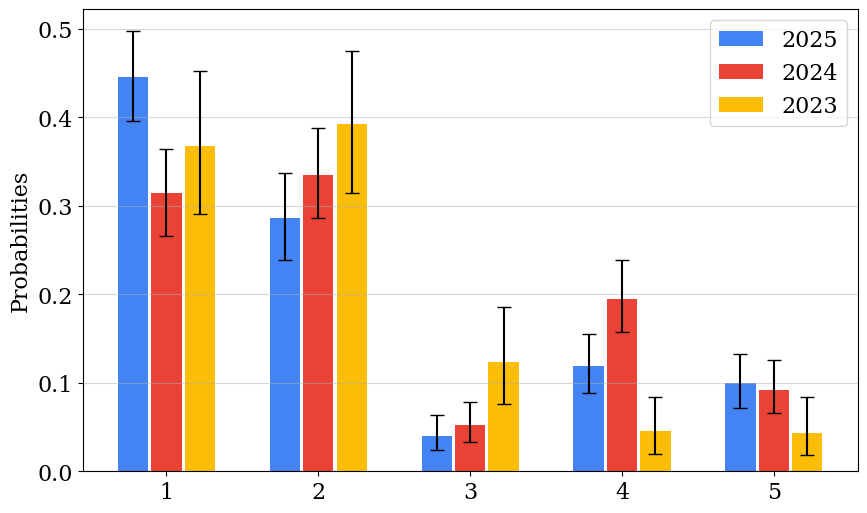

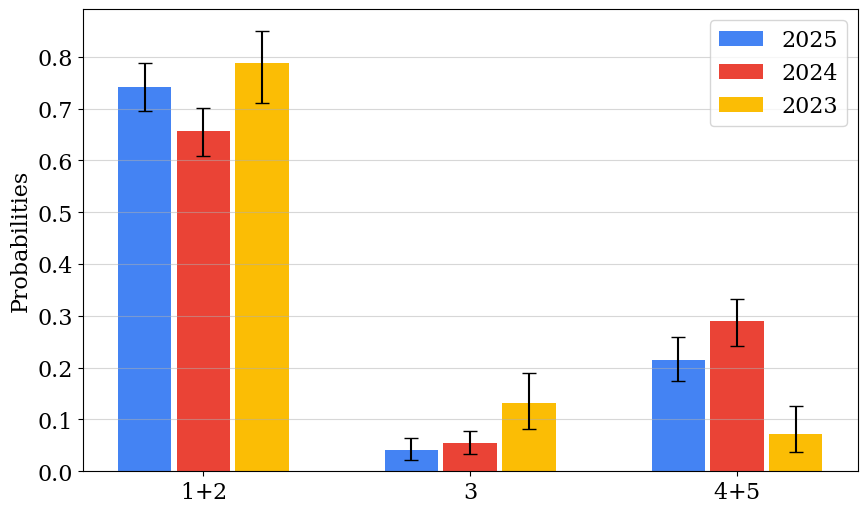

In [98]:



alpha_val = 1 #defaul
# alpha_val = 0.5 #Jeffrey's prior

n_sample = 1000 #for creating CI
ci_range = 16,84 #68% CI

for question in question_dict:
    curr_question = question_dict[question][0].split(',')[1]

    xlabels = np.array(question_dict[question][2].split(',')[1:6]).astype(int)
    data = {}
    curr_used = 0
    for j in range(3,len(question_dict[question])):
        curr_entry = question_dict[question][j].split(',')
        year = int(curr_entry[0])
        data[year] = {}
        try:
            data[year]['counts'] = np.array(curr_entry[1:6]).astype(int)
        except:
            data[year]['counts'] = np.zeros(len(curr_entry[1:6]))*np.nan
            for ind in range(1,6):
                if curr_entry[ind] == '':
                    continue
                else:
                    data[year]['counts'][ind-1] = int(curr_entry[ind])
        if np.any(np.isfinite(data[year]['counts'])):
            curr_used += 1
        data[year]['total'] = np.sum(data[year]['counts'])
        alpha_0 = np.sum(data[year]['counts']+alpha_val)
        data[year]['prob_means'] = (data[year]['counts']+alpha_val)/alpha_0
        data[year]['prob_uncerts'] = np.sqrt((alpha_val+data[year]['counts'])*(alpha_0-alpha_val-data[year]['counts'])/(alpha_0**2*(alpha_0+1)))

        samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)
        data[year]['prob_meds'] = np.nanmedian(samples,axis=0)
    
        data[year]['prob_CI'] = np.percentile(samples,ci_range,axis=0)

        data[year]['counts_hml'] = np.array([data[year]['counts'][0]+data[year]['counts'][1],
                                                      data[year]['counts'][2],
                                                     data[year]['counts'][3]+data[year]['counts'][4]])
        alpha_0 = np.sum(data[year]['counts_hml']+alpha_val)
        data[year]['prob_means_hml'] = (data[year]['counts_hml']+alpha_val)/alpha_0
        data[year]['prob_uncerts_hml'] = np.sqrt((alpha_val+data[year]['counts_hml'])*(alpha_0-alpha_val-data[year]['counts_hml'])/(alpha_0**2*(alpha_0+1)))

        samples = np.random.dirichlet(data[year]['counts_hml']+alpha_val,size=n_sample)
        data[year]['prob_meds_hml'] = np.nanmedian(samples,axis=0)
    
        data[year]['prob_CI_hml'] = np.percentile(samples,ci_range,axis=0)

    legend_labels = np.array(list(data.keys()))
    
    x = xlabels
    width = 0.2

    x_offsets = (np.arange(curr_used)-curr_used//2)*width*1.1

    print(question,curr_question)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for year_ind,year in enumerate(data):
        if not np.any(np.isfinite(data[year]['prob_meds'])):
            continue
        # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
        rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds'], width, 
                       yerr=(data[year]['prob_CI']-data[year]['prob_meds'])*np.array([-1,1])[:,None],
                       capsize=5, label=year, color=color_hex[year_ind])
    # rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

    ax.grid(visible=None, which='major', axis='y', alpha=0.5)
    ax.set_ylabel('Probabilities')
    # ax.set_title(curr_question)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels)
    ylim = ax.get_ylim()
    ax.set_ylim(0,ylim[1])
    ax.legend()

    plt.savefig('CCC_2025_figures/Q%02d.png'%(question))
    
    plt.show()

    x = np.arange(3).astype(int)
    x_offsets = (np.arange(curr_used)-curr_used//2)*width*1.1
    xlabels = ['1$+$2','3','4$+$5']

    fig, ax = plt.subplots(figsize=(10, 6))
    for year_ind,year in enumerate(data):
        if not np.any(np.isfinite(data[year]['prob_meds_hml'])):
            continue
        # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
        rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds_hml'], width, 
                       yerr=(data[year]['prob_CI_hml']-data[year]['prob_meds_hml'])*np.array([-1,1])[:,None],
                       capsize=5, label=year, color=color_hex[year_ind])
    # rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

    ax.grid(visible=None, which='major', axis='y', alpha=0.5)
    ax.set_ylabel('Probabilities')
    # ax.set_title(curr_question)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ylim = ax.get_ylim()
    ax.set_ylim(0,ylim[1])
    ax.legend()

    plt.savefig('CCC_2025_figures/Q%02d_hml.png'%(question))
    
    plt.show()


14 I feel welcome in my home department


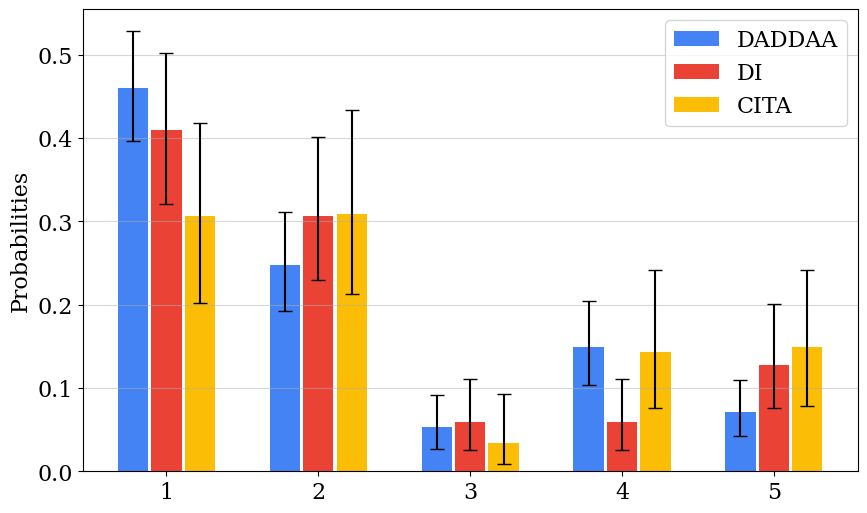

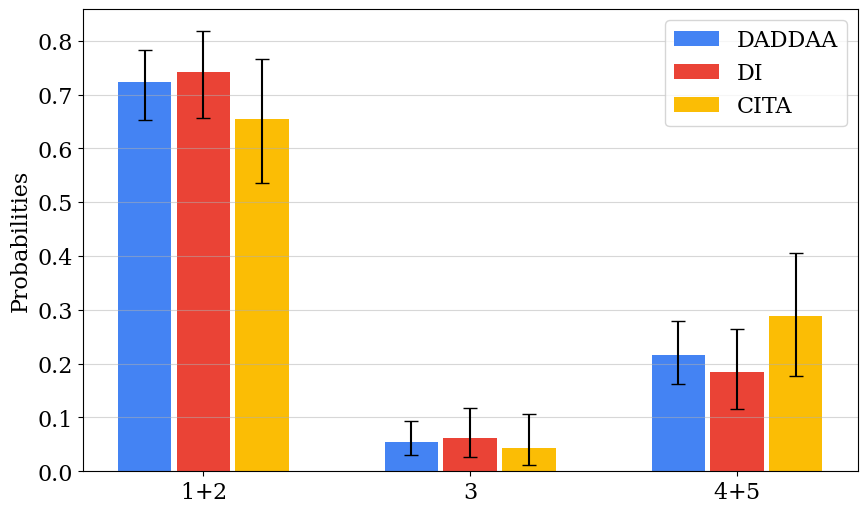

In [99]:
xlabels = np.array(question_dict[0][2].split(',')[1:6]).astype(int)

question = max(question_dict.keys())+1

print(question,'I feel welcome in my home department')


data = {}
data['DADDAA'] = {'counts':np.array([23, 12,  2,  7,  3])}
data['DI'] = {'counts':np.array([11,  8,  1,  1,  3])}
data['CITA'] = {'counts':np.array([5, 5, 0, 2, 2])}

legend_labels = np.array(list(data.keys()))
curr_used = 0

for year in data:
    if np.any(np.isfinite(data[year]['counts'])):
        curr_used += 1
    data[year]['total'] = np.sum(data[year]['counts'])
    alpha_0 = np.sum(data[year]['counts']+alpha_val)
    data[year]['prob_means'] = (data[year]['counts']+alpha_val)/alpha_0
    data[year]['prob_uncerts'] = np.sqrt((alpha_val+data[year]['counts'])*(alpha_0-alpha_val-data[year]['counts'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)
    data[year]['prob_meds'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI'] = np.percentile(samples,ci_range,axis=0)

    data[year]['counts_hml'] = np.array([data[year]['counts'][0]+data[year]['counts'][1],
                                                  data[year]['counts'][2],
                                                 data[year]['counts'][3]+data[year]['counts'][4]])
    alpha_0 = np.sum(data[year]['counts_hml']+alpha_val)
    data[year]['prob_means_hml'] = (data[year]['counts_hml']+alpha_val)/alpha_0
    data[year]['prob_uncerts_hml'] = np.sqrt((alpha_val+data[year]['counts_hml'])*(alpha_0-alpha_val-data[year]['counts_hml'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts_hml']+alpha_val,size=n_sample)
    data[year]['prob_meds_hml'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI_hml'] = np.percentile(samples,ci_range,axis=0)

x = xlabels
width = 0.2

x_offsets = (np.arange(len(legend_labels))-len(legend_labels)//2)*width*1.1

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds'], width, 
                   yerr=(data[year]['prob_CI']-data[year]['prob_meds'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d.png'%(question))

plt.show()

x = np.arange(3).astype(int)
x_offsets = (np.arange(len(data))-len(data)//2)*width*1.1
xlabels = ['1$+$2','3','4$+$5']

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds_hml'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds_hml'], width, 
                   yerr=(data[year]['prob_CI_hml']-data[year]['prob_meds_hml'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d_hml.png'%(question))

plt.show()



15 I feel welcome in DADDAA


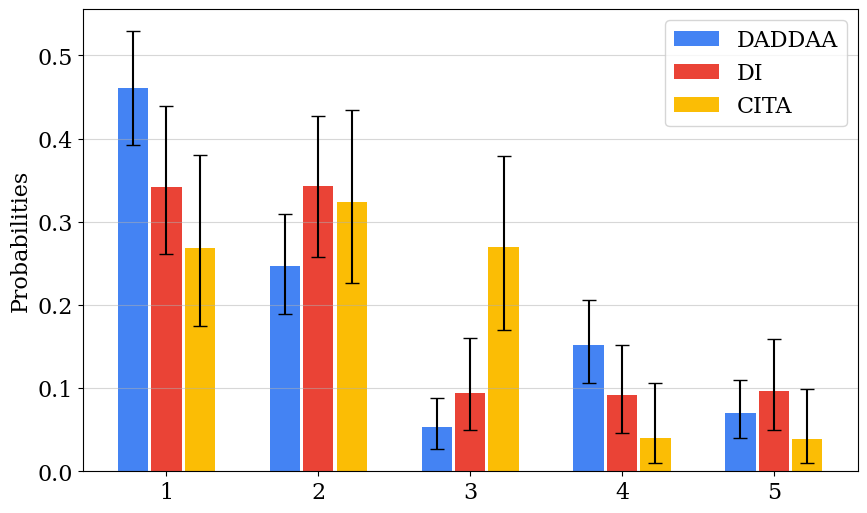

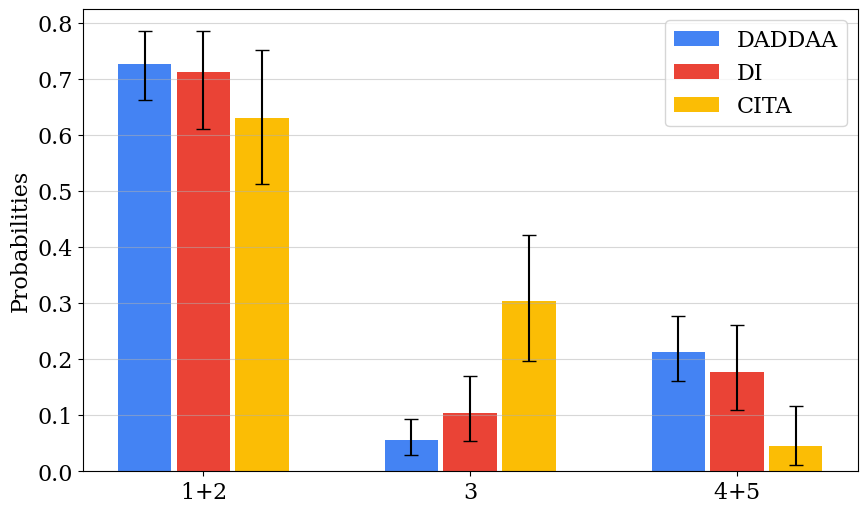

In [100]:
xlabels = np.array(question_dict[0][2].split(',')[1:6]).astype(int)

question = max(question_dict.keys())+2

print(question,'I feel welcome in DADDAA')


data = {}
data['DADDAA'] = {'counts':np.array([23, 12,  2,  7,  3])}
data['DI'] = {'counts':np.array([9,  9,  2,  2,  2])}
data['CITA'] = {'counts':np.array([4, 5, 4, 0, 0])}

legend_labels = np.array(list(data.keys()))
curr_used = 0

for year in data:
    if np.any(np.isfinite(data[year]['counts'])):
        curr_used += 1
    data[year]['total'] = np.sum(data[year]['counts'])
    alpha_0 = np.sum(data[year]['counts']+alpha_val)
    data[year]['prob_means'] = (data[year]['counts']+alpha_val)/alpha_0
    data[year]['prob_uncerts'] = np.sqrt((alpha_val+data[year]['counts'])*(alpha_0-alpha_val-data[year]['counts'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)
    data[year]['prob_meds'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI'] = np.percentile(samples,ci_range,axis=0)

    data[year]['counts_hml'] = np.array([data[year]['counts'][0]+data[year]['counts'][1],
                                                  data[year]['counts'][2],
                                                 data[year]['counts'][3]+data[year]['counts'][4]])
    alpha_0 = np.sum(data[year]['counts_hml']+alpha_val)
    data[year]['prob_means_hml'] = (data[year]['counts_hml']+alpha_val)/alpha_0
    data[year]['prob_uncerts_hml'] = np.sqrt((alpha_val+data[year]['counts_hml'])*(alpha_0-alpha_val-data[year]['counts_hml'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts_hml']+alpha_val,size=n_sample)
    data[year]['prob_meds_hml'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI_hml'] = np.percentile(samples,ci_range,axis=0)

x = xlabels
width = 0.2

x_offsets = (np.arange(len(legend_labels))-len(legend_labels)//2)*width*1.1

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds'], width, 
                   yerr=(data[year]['prob_CI']-data[year]['prob_meds'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d.png'%(question))

plt.show()

x = np.arange(3).astype(int)
x_offsets = (np.arange(len(data))-len(data)//2)*width*1.1
xlabels = ['1$+$2','3','4$+$5']

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds_hml'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds_hml'], width, 
                   yerr=(data[year]['prob_CI_hml']-data[year]['prob_meds_hml'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d_hml.png'%(question))

plt.show()



16 I feel welcome in DI


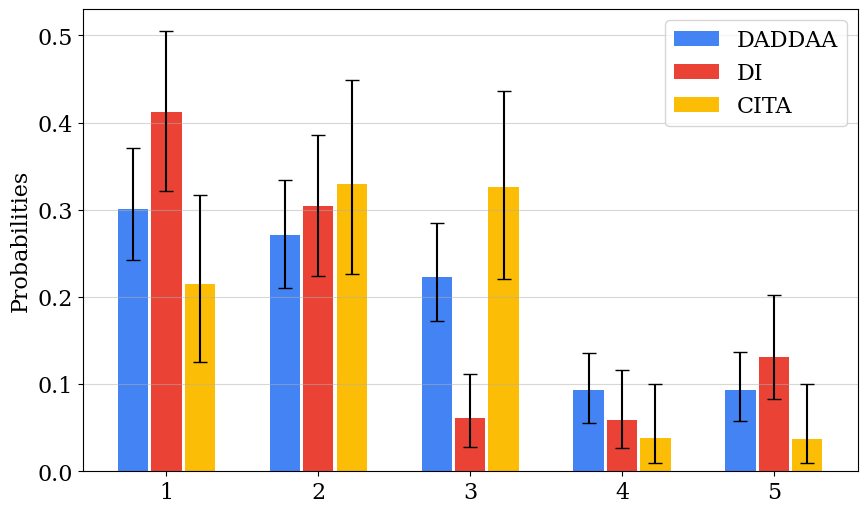

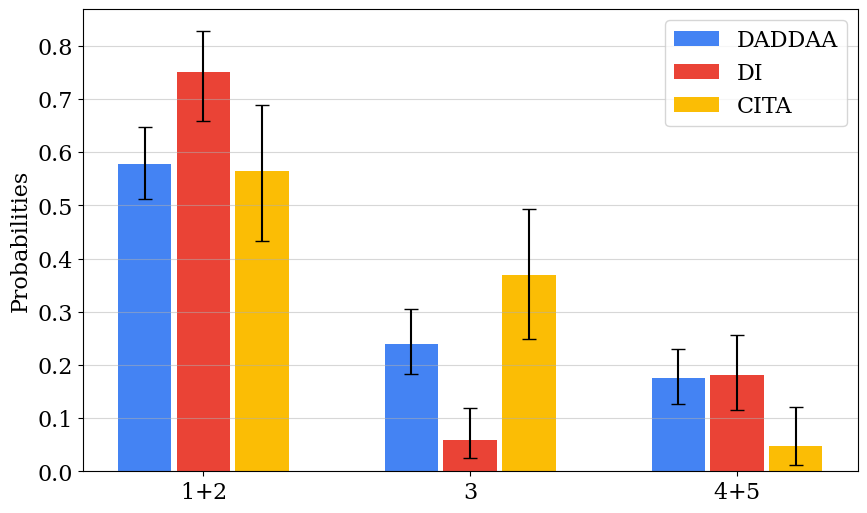

In [101]:
xlabels = np.array(question_dict[0][2].split(',')[1:6]).astype(int)

question = max(question_dict.keys())+3

print(question,'I feel welcome in DI')


data = {}
data['DADDAA'] = {'counts':np.array([15, 13,  11,  4,  4])}
data['DI'] = {'counts':np.array([11,  8,  1,  1,  3])}
data['CITA'] = {'counts':np.array([3, 5, 5, 0, 0])}

legend_labels = np.array(list(data.keys()))
curr_used = 0

for year in data:
    if np.any(np.isfinite(data[year]['counts'])):
        curr_used += 1
    data[year]['total'] = np.sum(data[year]['counts'])
    alpha_0 = np.sum(data[year]['counts']+alpha_val)
    data[year]['prob_means'] = (data[year]['counts']+alpha_val)/alpha_0
    data[year]['prob_uncerts'] = np.sqrt((alpha_val+data[year]['counts'])*(alpha_0-alpha_val-data[year]['counts'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)
    data[year]['prob_meds'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI'] = np.percentile(samples,ci_range,axis=0)

    data[year]['counts_hml'] = np.array([data[year]['counts'][0]+data[year]['counts'][1],
                                                  data[year]['counts'][2],
                                                 data[year]['counts'][3]+data[year]['counts'][4]])
    alpha_0 = np.sum(data[year]['counts_hml']+alpha_val)
    data[year]['prob_means_hml'] = (data[year]['counts_hml']+alpha_val)/alpha_0
    data[year]['prob_uncerts_hml'] = np.sqrt((alpha_val+data[year]['counts_hml'])*(alpha_0-alpha_val-data[year]['counts_hml'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts_hml']+alpha_val,size=n_sample)
    data[year]['prob_meds_hml'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI_hml'] = np.percentile(samples,ci_range,axis=0)

x = xlabels
width = 0.2

x_offsets = (np.arange(len(legend_labels))-len(legend_labels)//2)*width*1.1

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds'], width, 
                   yerr=(data[year]['prob_CI']-data[year]['prob_meds'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d.png'%(question))

plt.show()

x = np.arange(3).astype(int)
x_offsets = (np.arange(len(data))-len(data)//2)*width*1.1
xlabels = ['1$+$2','3','4$+$5']

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds_hml'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds_hml'], width, 
                   yerr=(data[year]['prob_CI_hml']-data[year]['prob_meds_hml'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d_hml.png'%(question))

plt.show()



17 I feel welcome in CITA


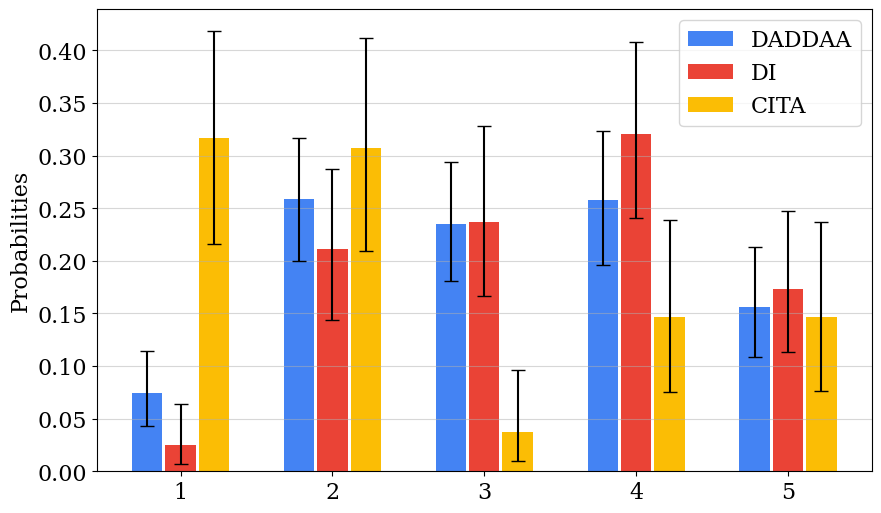

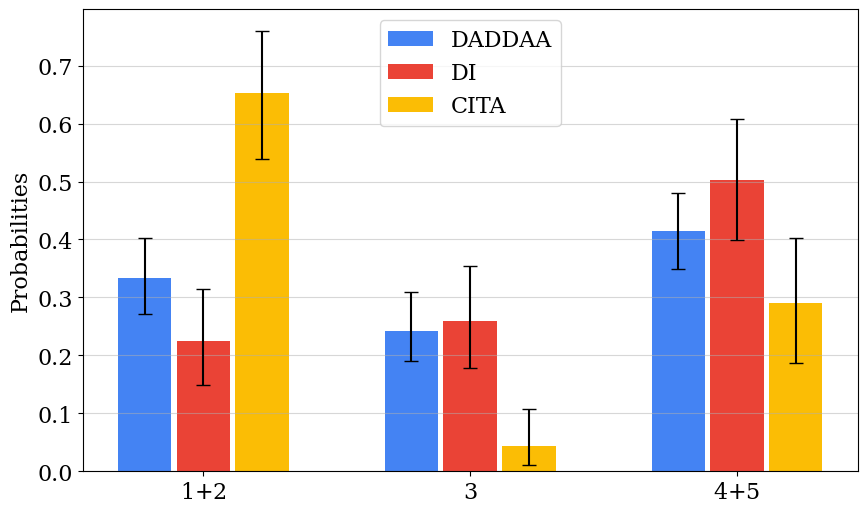

In [102]:
xlabels = np.array(question_dict[0][2].split(',')[1:6]).astype(int)

question = max(question_dict.keys())+4

print(question,'I feel welcome in CITA')


data = {}
data['DADDAA'] = {'counts':np.array([3, 12,  11,  12,  7])}
data['DI'] = {'counts':np.array([0,  5,  6,  8,  4])}
data['CITA'] = {'counts':np.array([5, 5, 0, 2, 2])}

legend_labels = np.array(list(data.keys()))
curr_used = 0

for year in data:
    if np.any(np.isfinite(data[year]['counts'])):
        curr_used += 1
    data[year]['total'] = np.sum(data[year]['counts'])
    alpha_0 = np.sum(data[year]['counts']+alpha_val)
    data[year]['prob_means'] = (data[year]['counts']+alpha_val)/alpha_0
    data[year]['prob_uncerts'] = np.sqrt((alpha_val+data[year]['counts'])*(alpha_0-alpha_val-data[year]['counts'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts']+alpha_val,size=n_sample)
    data[year]['prob_meds'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI'] = np.percentile(samples,ci_range,axis=0)

    data[year]['counts_hml'] = np.array([data[year]['counts'][0]+data[year]['counts'][1],
                                                  data[year]['counts'][2],
                                                 data[year]['counts'][3]+data[year]['counts'][4]])
    alpha_0 = np.sum(data[year]['counts_hml']+alpha_val)
    data[year]['prob_means_hml'] = (data[year]['counts_hml']+alpha_val)/alpha_0
    data[year]['prob_uncerts_hml'] = np.sqrt((alpha_val+data[year]['counts_hml'])*(alpha_0-alpha_val-data[year]['counts_hml'])/(alpha_0**2*(alpha_0+1)))

    samples = np.random.dirichlet(data[year]['counts_hml']+alpha_val,size=n_sample)
    data[year]['prob_meds_hml'] = np.nanmedian(samples,axis=0)

    data[year]['prob_CI_hml'] = np.percentile(samples,ci_range,axis=0)

x = xlabels
width = 0.2

x_offsets = (np.arange(len(legend_labels))-len(legend_labels)//2)*width*1.1

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds'], width, 
                   yerr=(data[year]['prob_CI']-data[year]['prob_meds'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d.png'%(question))

plt.show()

x = np.arange(3).astype(int)
x_offsets = (np.arange(len(data))-len(data)//2)*width*1.1
xlabels = ['1$+$2','3','4$+$5']

fig, ax = plt.subplots(figsize=(10, 6))
for year_ind,year in enumerate(data):
    if not np.any(np.isfinite(data[year]['prob_meds_hml'])):
        continue

    # rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_means'], width, yerr=data[year]['prob_uncerts'], capsize=5, label=year)
    rects = ax.bar(x+x_offsets[year_ind], data[year]['prob_meds_hml'], width, 
                   yerr=(data[year]['prob_CI_hml']-data[year]['prob_meds_hml'])*np.array([-1,1])[:,None],
                   capsize=5, label=year, color=color_hex[year_ind])
# rects2 = ax.bar(x + width/2, values2, width, yerr=errors2, capsize=5, label='Group 2')

ax.grid(visible=None, which='major', axis='y', alpha=0.5)
ax.set_ylabel('Probabilities')
# ax.set_title(curr_question)
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ylim = ax.get_ylim()
ax.set_ylim(0,ylim[1])
ax.legend()

plt.savefig('CCC_2025_figures/Q%02d_hml.png'%(question))

plt.show()

